<a href="https://colab.research.google.com/github/Chirag314/Randomforest-creditcarddata/blob/main/Randomforest_creditcarddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This notebook is copied from exercises from book Ensemble Machine Learning Cookbook.

In [84]:
#import required libraries
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# Read data from github. Use raw format and copy url# Note normal url and raw url will be different.
import pandas as pd
pd.options.display.max_rows=None
pd.options.display.max_columns=None
url = 'https://raw.githubusercontent.com/PacktPublishing/Ensemble-Machine-Learning-Cookbook/master/Chapter06/UCI_Credit_Card.csv'
df_creditcarddata = pd.read_csv(url)
#df = pd.read_csv(url)
print(df_creditcarddata.head(5))

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2     3913.0     3102.0      689.0        0.0        0.0   
1      0      2     2682.0     1725.0     2682.0     3272.0     3455.0   
2      0      0    29239.0    14027.0    13559.0    14331.0    14948.0   
3      0      0    46990.0    48233.0    49291.0    28314.0    28959.0   
4      0      0     8617.0     5670.0    35835.0    20940.0    19146.0   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0   

In [86]:
df_creditcarddata.shape

(30000, 25)

In [87]:
df_creditcarddata.dtypes
#df_backorder.describe()

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [88]:
# check missing values
df_creditcarddata.isnull().sum()
columns_with_missing_values=df_creditcarddata.columns[df_creditcarddata.isnull().any()]
df_creditcarddata[columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f780cff4750>,
      dtype=object)

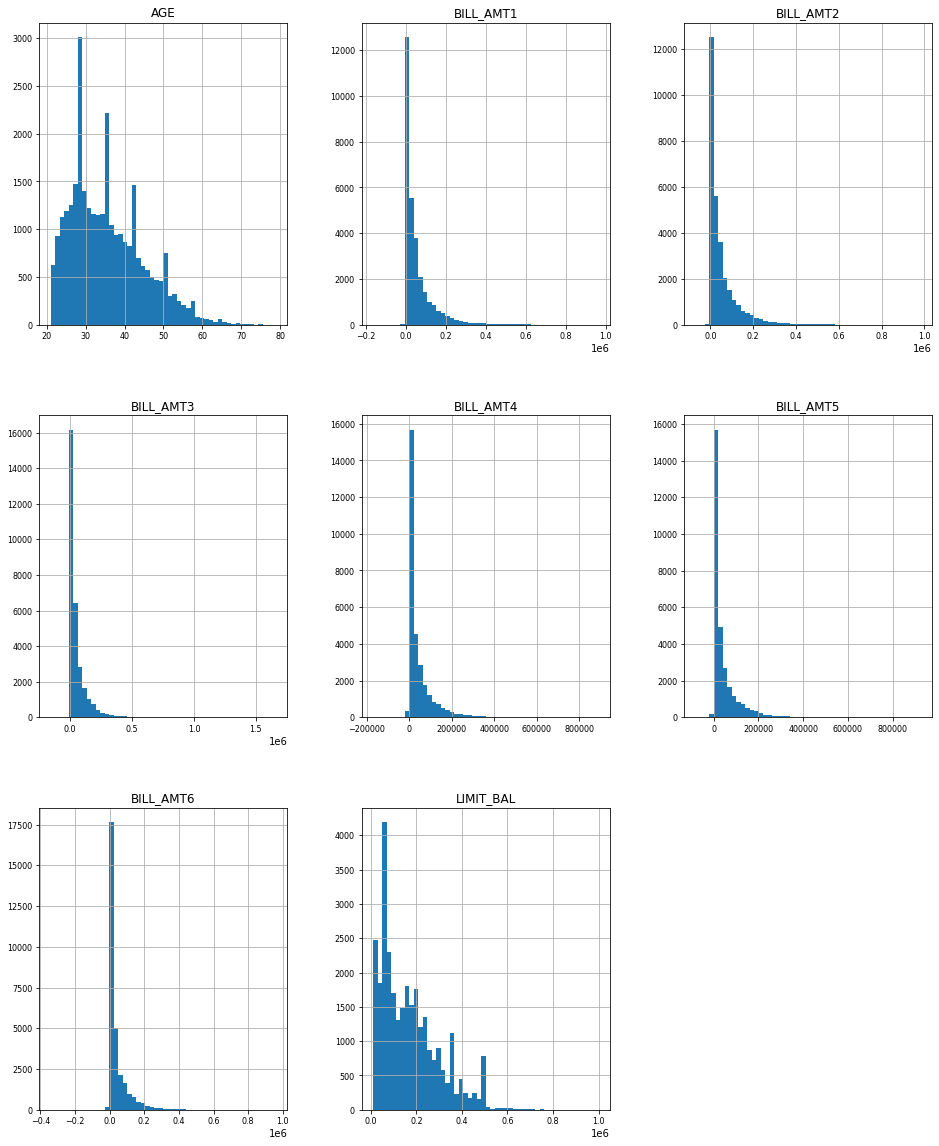

In [89]:
# Lets check selected data
selected_columns=df_creditcarddata[['AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6', 'LIMIT_BAL']]
selected_columns.hist(figsize=(16,20),bins=50,xlabelsize=8,ylabelsize=8)

#####WWe notice that there are no missing values in wine data

In [90]:
#Explore payment default s by age group
df_creditcarddata['agegroup']=pd.cut(df_creditcarddata['AGE'],range(0,100,10),right=False)
df_creditcarddata.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,agegroup
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,"[20, 30)"
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,"[20, 30)"
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,"[30, 40)"
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,"[30, 40)"
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,"[50, 60)"


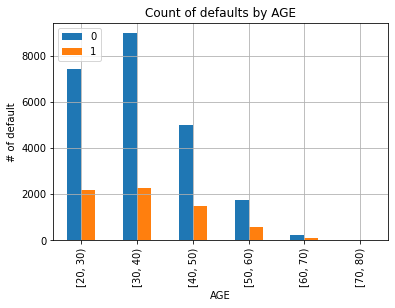

In [91]:
# Default vs age
pd.crosstab(df_creditcarddata.agegroup,df_creditcarddata["default.payment.next.month"]).plot(kind='bar',stacked=False,grid=True)
plt.title('Count of defaults by AGE')
plt.xlabel('AGE')
plt.ylabel('# of default')
plt.legend(loc='upper left')

In [92]:
df_creditcarddata.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,agegroup
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,"[20, 30)"
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,"[20, 30)"
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,"[30, 40)"
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,"[30, 40)"
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,"[50, 60)"


In [93]:
#Drop agegroup variable from data since we don not need it anymore
df_creditcarddata=df_creditcarddata.drop(columns=['agegroup'])

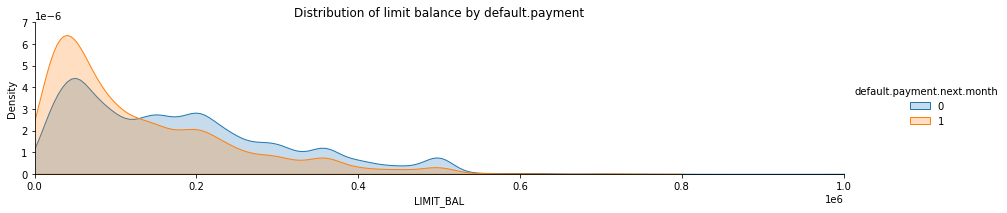

In [94]:
fig_facetgrid = sns.FacetGrid(df_creditcarddata, hue='default.payment.next.month', aspect=4)
fig_facetgrid.map(sns.kdeplot, 'LIMIT_BAL', shade=True)
max_limit_bal = df_creditcarddata['LIMIT_BAL'].max()
fig_facetgrid.set(xlim=(0,max_limit_bal));
fig_facetgrid.set(ylim=(0.0,0.000007));
fig_facetgrid.set(title='Distribution of limit balance by default.payment')
fig_facetgrid.add_legend()

In [95]:
#We can also assign labels to some of our variables to make the interpretations better. We assign labels for the Gender, Marriage, and Education variables.


In [96]:
GenderMap={2:'female',1:'Male'}
MarriageMap={1:'married',2:'single',3:'other',0:'other'}
EducationMap={1:'graduate school',2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown', 0:'unknown'}
df_creditcarddata['SEX']=df_creditcarddata['SEX'].map(GenderMap)
df_creditcarddata['MARRIAGE']=df_creditcarddata.MARRIAGE.map(MarriageMap)
df_creditcarddata['EDUCATION']=df_creditcarddata.EDUCATION.map(EducationMap)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_0'].astype(str)
#df_creditcarddata['PAY_0']=df_creditcarddata['PAY_1'].astype(str)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_2'].astype(str)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_3'].astype(str)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_4'].astype(str)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_5'].astype(str)
df_creditcarddata['PAY_0']=df_creditcarddata['PAY_6'].astype(str)

In [97]:
#We separate our features and the response set. We also split our data into training and testing subsets.
predictor=df_creditcarddata.iloc[:,df_creditcarddata.columns!='default.payment.next.month']
target=df_creditcarddata.iloc[:,df_creditcarddata.columns=='default.payment.next.month']

#X_train,X_test, Y_train, Y_test=train_test_split(X,Y , random_state=1)

In [98]:
#We separate the numerical and non-numerical variables in our feature set:
categorical_columns=[col for col in predictor.columns.values if predictor[col].dtype=='object']

#Dataframe with categorical features
df_categorical=predictor[categorical_columns]

#dataframe with numerical features
df_numeric=predictor.drop(categorical_columns,axis=1)

In [99]:
#Dummy code categorical variables

In [100]:
dummy_code_cat_vars=pd.get_dummies(df_categorical,drop_first=True)
df_predictor=pd.concat([df_numeric,dummy_code_cat_vars],axis=1)

In [104]:
#Split data into training and test set
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test=train_test_split(df_predictor, target, test_size=0.3,random_state=0)
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)
print("Y_train :",Y_train.shape)
print("Y_test :",Y_test.shape)

X_train : (21000, 36)
X_test : (9000, 36)
Y_train : (21000, 1)
Y_test : (9000, 1)


In [105]:
#Scale numeric features with standard scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
#X_train_scaled=scaler.fit(X_train)
#X_test_scaled=scaler.fit(X_test)

In [103]:
#We might notice that the column names have been changed to numbers. We assign the columns names and index values back to the scaled DataFrame:
#X_train_scaled.columns=X_train.columns.values
#X_test_scaled.columns=X_test.columns.values
#X_train_scaled.index=X_train.index.values
#X_test_scaled.index=X_test.index.values

#X_train=X_train_scaled
#X_test=X_test_scaled

In [106]:
# Fit the model
from sklearn.ensemble import RandomForestClassifier

classifier=RandomForestClassifier(random_state=0,n_estimators=100,criterion='entropy',max_leaf_nodes=20,oob_score=True,n_jobs=-1)
model_rf=classifier.fit(X_train, Y_train)

In [108]:
# Check the score after passing test data
acc_random_forest=round(classifier.score(X_train,Y_train)*100,2)
print(round(acc_random_forest,2,),"%")

80.28 %


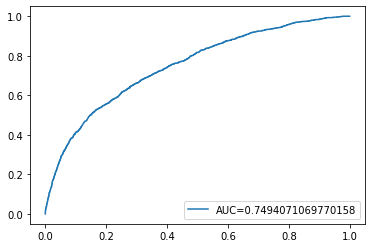

In [109]:
#We get the false positive rate (FPR) and true positive rate (TPR) by passing y_test and y_pred_proba to roc_curve(). We also get the auc value using roc_auc_score(). Using the FPR, TPR, and the AUC value, we plot the ROC curve with the AUC value annotated on the plot:
from sklearn import metrics
y_pred_proba=model_rf.predict_proba(X_test)[::,1]
fpr,tpr,_=metrics.roc_curve(Y_test,y_pred_proba)
auc=metrics.roc_auc_score(Y_test,y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [110]:
# We can also evaluate other scores

y_pred_rf=model_rf.predict(X_test)
evaluation_score=pd.Series({'Model':"Random forest Classifier",
                            'ROC SCORE':metrics.roc_auc_score(Y_test,y_pred_rf),
                            'Precision score ': metrics.precision_score(Y_test,y_pred_rf),
                            'Recall score':metrics.recall_score(Y_test,y_pred_rf),
                            'Accuracy score':metrics.accuracy_score(Y_test,y_pred_rf),
                            'Kappa score ':metrics.cohen_kappa_score(Y_test,y_pred_rf)})
print(evaluation_score)


Model               Random forest Classifier
ROC SCORE                           0.581564
Precision score                     0.637755
Recall score                        0.193299
Accuracy score                      0.802444
Kappa score                         0.218292
dtype: object


In [111]:
#We can also evaluate a few statistics based on the class of the target variable, which in this case is 0 or 1:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      7060
           1       0.64      0.19      0.30      1940

    accuracy                           0.80      9000
   macro avg       0.73      0.58      0.59      9000
weighted avg       0.78      0.80      0.76      9000



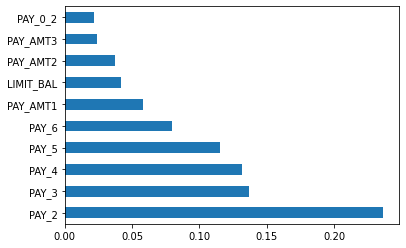

In [112]:
# We can plot the top 10 variables by feature importance to see which variables are important for the model:
feature_importances=pd.Series(classifier.feature_importances_,index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')

In [ ]:
#We will now use a code to plot the confusion matrix.
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes,rotation=45)
  plt.yticks(tick_marks, classes)

  thresh=cm.max()
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i ,cm[i,j],horizontalalighment='center',
             color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('Actuals')
    plt.xlabel('Predicted')

In [ ]:
# This  variable holds class labels of our target
target_names=['1','2','3']
import itertools
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, predictedvalues)

# Plotting the confusion matriz
plt.figure(figsize=(3,3))
plot_confusion_matrix(cm=cm,classes=target_names,normalize=False)
plt.show()


In [ ]:
#We start by creating the bootstrap samples
def create_bootstrap_oob(df):
  global df_oob
  global df_bootstrap_sample
  #Creating bootstrap sample
  df_bootstrap_sample=resample(df,replace=True,n_samples=100)
  #creating oob sample
  bootstrap_sample_index=tuple(df_bootstrap_sample.index)
  bootstrap_df=df.index.isin(bootstrap_sample_index)
  df_oob=df[~bootstrap_df]

We build models using the bootstrap samples and average the cost function across all the models. We use the SGDRegressor() on each bootstrap sample. In the following code block, we reuse our previously written custom function, create_bootstrap_oob(), to create the bootstrap and OOB error samples:

In [ ]:
iteration=50
mse_each_iteration=list()
lm=SGDRegressor()
total_mse=0
average_mse=list()

for i in range(iteration):
  create_bootstrap_oob(df_winedata)

  #bootstrap sample features set
  x_bs=df_bootstrap_sample.iloc[:,1:8]
  #Bootstrap sample response variable
  y_bs=df_bootstrap_sample.iloc[:,0]

  #oob sample features set
  x_oob=df_oob.iloc[:,1:8]
  #OB sample response variable
  y_oob=df_oob.iloc[:,0]

  # fit your model with bootstrap sample
  lm=SGDRegressor()
  lm.fit(x_bs,y_bs)

  #test your model on out of bag sample
  predictedvalues=lm.predict(x_oob)

  #capture mse for the predicted values
  mse=mean_squared_error(y_oob,predictedvalues)

  #create a list of mse values
  mse_each_iteration.append(mse)

In [ ]:
#Plot mse for each model built
import matplotlib.pyplot as plt
f, ax=plt.subplots(figsize=(8,6))

plt.plot(mse_each_iteration,'c--',label='MSE by iterations')

plt.xlabel('Iterations')
plt.ylabel('Mean squared error')
plt.legend(loc=1)
plt.show()

In [ ]:
# We can also gridsearchcv

from sklearn.model_selection import GridSearchCV
param_values={'n_estimators':[10,20,25,30],'base_estimator__max_leaf_nodes':[5,10,15,20],'base_estimator__max_depth':[3,4,5]}

In [ ]:
# Instantiate the classifier
dt_model=DecisionTreeClassifier()
bag_dt_model_grid=BaggingClassifier(base_estimator=dt_model,oob_score=True,random_state=1)

In [ ]:
# We use GridSearchCV to determine the best parameters
bc_grid=GridSearchCV(estimator=bag_dt_model,param_grid=param_values,cv=20,n_jobs=-1)
bc_grid.fit(X_train, Y_train)
best_params=bc_grid.best_params_
print(best_params)

In [ ]:
best_dt_model=DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=10,max_depth=3)
final_bag_dt_model=BaggingClassifier(base_estimator=best_dt_model,n_estimators=150,bootstrap=True,random_state=1,oob_score=True)

In [ ]:
# Check accuracy of our OOB sample
final_bag_dt_model.fit(X_train,Y_train)
bag_predictedvalues=final_bag_dt_model.predict(X_test)

# See the OOB accuracy
acc_oob=final_bag_dt_model.oob_score_
print(acc_oob)